In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/projects/cse-252-d/

# Set the path to your data directory on Google Drive
data_dir = '/dataset'

Mounted at /content/drive
/content/drive/My Drive/projects/cse-252-d


In [12]:
import torchvision
train_dataset =torchvision.datasets.VOCSegmentation(root='./data',year='2007',download=True,image_set='train')
val_dataset = torchvision.datasets.VOCSegmentation(root='./data',year='2007',download=True,image_set='val')
test_dataset = torchvision.datasets.VOCSegmentation(root='./data',year='2007',download=True,image_set='test')

100%|██████████| 460032000/460032000 [00:16<00:00, 28490640.33it/s]


Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


100%|██████████| 451020800/451020800 [00:15<00:00, 28249785.80it/s]


Extracting ./data/VOCtest_06-Nov-2007.tar to ./data


In [14]:
!cd data

In [16]:
!wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar


--2023-06-06 16:59:40--  http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar [following]
--2023-06-06 16:59:40--  https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/octet-stream]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================>] 430.13M  54.8MB/s    in 8.5s    

2023-06-06 16:59:49 (50.6 MB/s) - ‘VOCtest_06-Nov-2007.tar’ saved [451020800/451020800]



In [ ]:
!tar -xvf VOCtest_06-Nov-2007.tar

In [47]:
import os
from PIL import Image
from torch.utils import data
import torchvision.transforms as transforms
import random

num_classes = 21
ignore_label = 255
root = './data'

'''
color map
0=background, 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle # 6=bus, 7=car, 8=cat, 9=chair, 10=cow, 11=diningtable,
12=dog, 13=horse, 14=motorbike, 15=person # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
'''


#Feel free to convert this palette to a map
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]  #3 values- R,G,B for every class. First 3 values for class 0, next 3 for
#class 1 and so on......

'''
Depending on the mode, train or val or test, the function reads the train.txt, val.txt and test.txt files and returns a list of tuples of the form
(image_path, mask_path) for each image in the dataset, where image_path is the path to the image and mask_path is the path to the mask for that image. 
'''
def make_dataset(mode):
    assert mode in ['train', 'val', 'test']
    items = []
    if mode == 'train':
        img_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'JPEGImages')
        mask_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root, 'VOCdevkit', 'VOC2007', 'ImageSets', 'Segmentation', 'train.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    elif mode == 'val':
        img_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'JPEGImages')
        mask_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root, 'VOCdevkit', 'VOC2007', 'ImageSets', 'Segmentation', 'val.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    else:
        img_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'JPEGImages')
        mask_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root, 'VOCdevkit', 'VOC2007', 'ImageSets', 'Segmentation', 'test.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    return items




'''
The class VOC is a subclass of the class torch.utils.data.Dataset. It overrides the __len__ and __getitem__ methods.
The __len__ method returns the length of the dataset, i.e. the number of images in the dataset.
The __getitem__ method returns the image and the mask for the given index.
'''

class VOC(data.Dataset):
    def __init__(self, mode, transform=None, target_transform=None, common_transform=None):
        self.imgs = make_dataset(mode)
        if len(self.imgs) == 0:
            raise RuntimeError('Found 0 images, please check the data set')
        self.mode = mode
        self.transform = transform
        self.target_transform = target_transform
        self.common_transform = common_transform
        self.width = 224
        self.height = 224

    def __getitem__(self, index):
        
        img_path, mask_path = self.imgs[index]
        img = Image.open(img_path).convert('RGB').resize((self.width, self.height))
        mask = Image.open(mask_path).resize((self.width, self.height))

        if self.common_transform is not None:
            img, mask = self.common_transform((img,mask)) 

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            mask = self.target_transform(mask)

        mask[mask==ignore_label]=0

        return img, mask

    def __len__(self):
        return len(self.imgs)


if __name__=="__main__":
    voc = VOC("train")

    print(len(voc))

209


In [48]:
import numpy as np 
class MaskToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.int32)).long()


mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# common_transform = transforms.Compose([
#     # voc.MirrorFlip(0.5),
#     # voc.Rotate(10),
#     # voc.CenterCrop(180)
# ])

input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*mean_std)
])

target_transform = transforms.Compose([
    MaskToTensor()
])

# augmented_train_dataset =voc.VOC('train', transform=input_transform, target_transform=target_transform, common_transform=common_transform)
# augmented_val_dataset = voc.VOC('val', transform=input_transform, target_transform=target_transform, common_transform=common_transform)
# augmented_test_dataset = voc.VOC('test', transform=input_transform, target_transform=target_transform, common_transform=common_transform)

original_train_dataset =VOC('train', transform=input_transform, target_transform=target_transform)
original_val_dataset = VOC('val', transform=input_transform, target_transform=target_transform)
original_test_dataset = VOC('test', transform=input_transform, target_transform=target_transform)


In [32]:
original_train_dataset[0][1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [50]:
from torch.utils.data import DataLoader, ConcatDataset

NUM_WORKERS = 4
PREFETCH_FACTOR = 2 # improves data transfer speed between GPU and CPU and reduces GPU wait time
train_loader = DataLoader(dataset=original_train_dataset, batch_size= 16, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)
val_loader = DataLoader(dataset=original_val_dataset, batch_size= 16, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)
test_loader = DataLoader(dataset=original_test_dataset, batch_size= 16, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [78]:
for images, masks in train_loader:
  images = images.to(device)
  masks = masks.to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [69]:
images[0]

tensor([[[ 0.5878,  0.5878,  0.5878,  ...,  0.4508,  0.3823,  0.3309],
         [ 0.6049,  0.6049,  0.6221,  ...,  0.4166,  0.4166,  0.4337],
         [ 0.6221,  0.6221,  0.6221,  ...,  0.4679,  0.4679,  0.4679],
         ...,
         [-0.6281, -0.1828, -0.4054,  ..., -0.1486, -0.2171, -0.7137],
         [-0.4054, -0.6623, -0.5596,  ..., -0.6281, -0.6109, -0.5938],
         [-0.4739, -0.4911, -0.5424,  ..., -0.5424, -0.4568, -0.7137]],

        [[ 1.5357,  1.5357,  1.5357,  ...,  1.3256,  1.3606,  1.3256],
         [ 1.5532,  1.5532,  1.5707,  ...,  1.4132,  1.3431,  1.3431],
         [ 1.5707,  1.5707,  1.5707,  ...,  1.3782,  1.3957,  1.3957],
         ...,
         [-0.1099,  0.3277,  0.1527,  ..., -0.2500, -0.3025, -0.7927],
         [ 0.0476, -0.2150, -0.0749,  ..., -0.7402, -0.7227, -0.7227],
         [-0.0399, -0.0749, -0.1099,  ..., -0.6176, -0.6176, -0.9153]],

        [[ 2.3611,  2.3786,  2.3786,  ...,  2.1171,  2.1346,  2.0997],
         [ 2.3960,  2.3960,  2.4134,  ...,  2

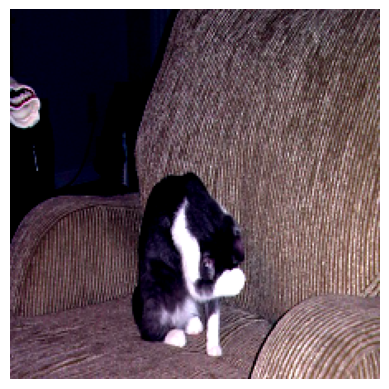

In [80]:
# for images, masks in train_loader:
#   image = images.to(device)
#   mask = masks.to(device)
#   break


import matplotlib.pyplot as plt
import numpy as np

# Assuming data is a tuple (image, label)
image = images[0]
# image = masks[0]
# Convert the tensor image to NumPy array and transpose the dimensions
image = image.numpy().transpose((1, 2, 0))

# Denormalize the image (if it was normalized during transformation)
mean = (0.5, 0.5, 0.5)  # Mean used for normalization
std = (0.5, 0.5, 0.5)  # Standard deviation used for normalization
image = image * std + mean

# Clip the pixel values to [0, 1] range in case of any numerical instability
image = np.clip(image, 0, 1)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()

### Building the model

Segmentation model

In [ ]:
# Define the Backbone class to evaluate the self-supervised learned encoder
class Backbone(nn.Module):
    def __init__(self, out_dim):
        super(Backbone, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the fully connected (linear) layer
        self.fc = nn.Linear(in_features=1568, out_features=out_dim)
    
    def forward(self, x):
        # Perform forward pass
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = self.fc(x)
        
        return x

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the U-Net architecture with a modified encoder
class UNet(nn.Module):
    def __init__(self, pretrained_encoder):
        super(UNet, self).__init__()
        
        # Load the pretrained encoder
        self.encoder = pretrained_encoder
        
        # Define the U-Net decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Add the final segmentation layer
        self.segmentation = nn.Conv2d(4, num_classes, kernel_size=1)

    def forward(self, x):
        # Pass the input through the encoder
        encoded_features = self.encoder(x)
        
        # Pass the encoded features through the decoder
        decoded_features = self.decoder(encoded_features)
        
        # Perform the final segmentation
        segmentation_map = self.segmentation(decoded_features)
        
        return segmentation_map


In [ ]:
# Define the number of classes for the segmentation task
num_classes = 20

# Create an instance of the Backbone model to evaluate the self-supervised learned encoder
backbone_model = Backbone(out_dim=16)  # Adjust the out_dim to match the output size of your encoder

# Create an instance of the U-Net model with the modified encoder
model = UNet(backbone_model)

# Load the model weights of the self-supervised learned encoder
model.encoder.load_state_dict(torch.load('pre-trained-weights.pth'))

# Set the model in evaluation mode
model.eval()

# Perform inference on a test image
input_image = torch.randn(1, 1, 256, 256)  # Example test
